In [1]:
pip install pandas scikit-learn joblib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')


In [3]:
project_id = 'wagon-bootcamp-2106'
dataset_id = 'voicelens'

data_review_and_rating_for_amazon_path = "https://storage.googleapis.com/voicelens/review-and-rating-for-amazon.csv"
data_trip_advisor_hotel_reviews_path = "https://storage.googleapis.com/voicelens/trip-advisor-hotel-reviews.csv"
data_trustpilot_reviews_dataset_path = "https://storage.googleapis.com/voicelens/trustpilot-reviews-dataset.csv"
data_hotel_reviews_data_in_europe_path = "https://storage.googleapis.com/voicelens/515k-hotel-reviews-data-in-europe.csv"
data_amazon_product_reviews_path = "https://storage.googleapis.com/voicelens/amazon-product-reviews.csv"



STARTING COMPREHENSIVE DATA CLEANING
Cleaning comment column...
Cleaning rating column...

Before cleaning: 12948 rows
After removing duplicates: 12943 rows

sentiment_rating
negative    7457
positive    4897
neutral      589
Name: count, dtype: int64


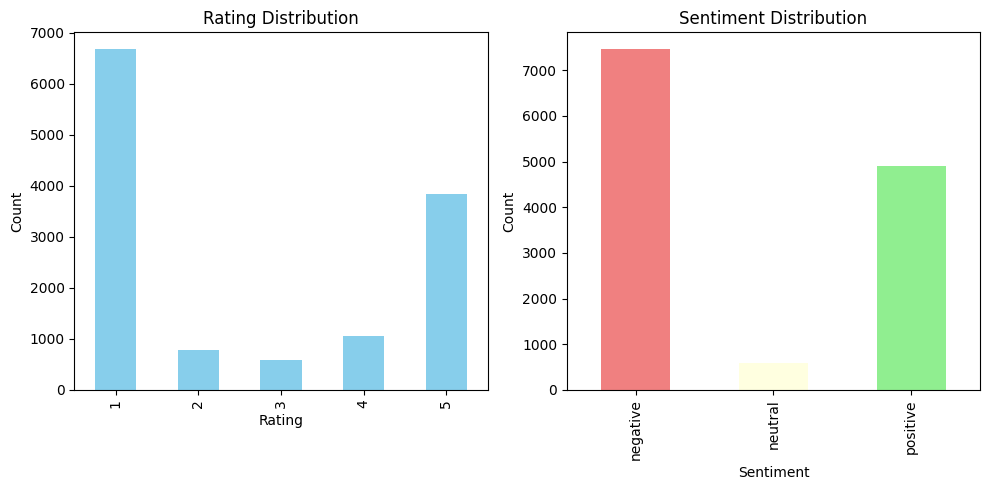

In [6]:
# Load the data with the working encoding
df = pd.read_csv(data_review_and_rating_for_amazon_path, encoding="latin-1")
df.head()

# 4. Clean COMMENT column - REPLACE NEWLINES WITH SPACES
def clean_comment(comment):
    if pd.isna(comment):
        return ""

    if isinstance(comment, str):
        # Fix encoding issues first
        encoding_fixes = {
            'Ã¤': 'ä', 'Ã¶': 'ö', 'Ã¼': 'ü', 'ÃŸ': 'ß',
            'Ã©': 'é', 'Ã¢': 'â', 'Ã®': 'î', 'Ã´': 'ô',
            'Ã¡': 'á', 'Ã³': 'ó', 'Ãº': 'ú', 'Ã±': 'ñ',
            'Ã‰': 'É', 'Ã“': 'Ó', 'Ã‘': 'Ñ', 'Ã€': 'À',
            'Ãª': 'ê', 'Ã§': 'ç', 'Ã»': 'û', 'Ã¨': 'è',
            'Ã¬': 'ì', 'Ã²': 'ò', 'Ã¹': 'ù', 'Ã®': 'î'
        }

        for wrong, correct in encoding_fixes.items():
            comment = comment.replace(wrong, correct)

        # Remove Unicode escape sequences like <U+0085>
        comment = re.sub(r'<U\+\w+>', '', comment)

        # NORMALIZE LINE BREAKS - REPLACE ALL NEWLINES WITH SPACES
        comment = comment.replace('\r\r\n', ' ').replace('\r\n', ' ').replace('\n', ' ')

        # Remove extra whitespace (multiple spaces to single space)
        comment = re.sub(r'[ \t]+', ' ', comment)

        # Remove leading/trailing whitespace
        comment = comment.strip()

        # Remove any remaining non-printable characters except basic punctuation
        comment = re.sub(r'[^\x20-\x7EäöüßáéíóúñÁÉÍÓÚÑ]', '', comment)

        return comment

    return ""

# 5. Clean RATING column
def clean_rating(rating):
    if pd.isna(rating):
        return None

    try:
        # Handle string ratings
        if isinstance(rating, str):
            # Extract first numeric value
            match = re.search(r'(\d+)', rating)
            if match:
                rating = int(match.group(1))
            else:
                return None
        else:
            rating = int(float(rating))

        # Validate range
        if 1 <= rating <= 5:
            return rating
        else:
            return None

    except (ValueError, TypeError):
        return None


print("\n\nSTARTING COMPREHENSIVE DATA CLEANING")

print("Cleaning comment column...")
df['comment'] = df['comment'].apply(clean_comment)

print("Cleaning rating column...")
df['rating'] = df['rating'].apply(clean_rating)

# Remove rows with critical missing data
print(f"\nBefore cleaning: {len(df)} rows")

# Remove duplicates
df_clean = df.drop_duplicates(subset=['name', 'comment', 'date'], keep='first')
print(f"After removing duplicates: {len(df_clean)} rows\n")

# Create rating sentiment with text labels
def get_rating_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

df_clean['sentiment_rating'] = df_clean['rating'].apply(get_rating_sentiment)

# Reset index
df_clean = df_clean.reset_index(drop=True)

print(df_clean['sentiment_rating'].value_counts())

# Save the fully cleaned dataset
output_path = "../raw_data/review_for_amazon_fully_cleaned.csv"
df_clean.to_csv(output_path, encoding='utf-8', index=False)

df_clean.head()

# Visualize sentiment distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df_clean['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sentiment_counts = df_clean['sentiment_rating'].value_counts()
# Reorder for logical display: negative, neutral, positive
sentiment_counts = sentiment_counts.reindex(['negative', 'neutral', 'positive'])
sentiment_counts.plot(kind='bar', color=['lightcoral', 'lightyellow', 'lightgreen'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

Loading cleaned dataset...
Features (X) shape: (12943,)
Target (y) shape: (12943,)


STEP 3: TRAIN-TEST SPLIT
Training set size: 10354
Test set size: 2589

Training set sentiment distribution:
sentiment_rating
negative    5965
positive    3918
neutral      471
Name: count, dtype: int64

Test set sentiment distribution:
sentiment_rating
negative    1492
positive     979
neutral      118
Name: count, dtype: int64


STEP 4: CREATING TF-IDF FEATURES


STEP 5: BUILDING LOGISTIC REGRESSION MODEL
Pipeline created:
 1. TF-IDF Vectorizer → 2. Logistic Regression 

Logistic Regression parameters: 


STEP 6: TRAINING THE MODEL
Training the model...
✅ Model training completed!


STEP 7: MODEL EVALUATION
📊 Model Accuracy: 0.8540

📈 Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.92      0.91      0.91      1492
     neutral       0.14      0.24      0.17       118
    positive       0.92      0.84      0.87       979

    accuracy         

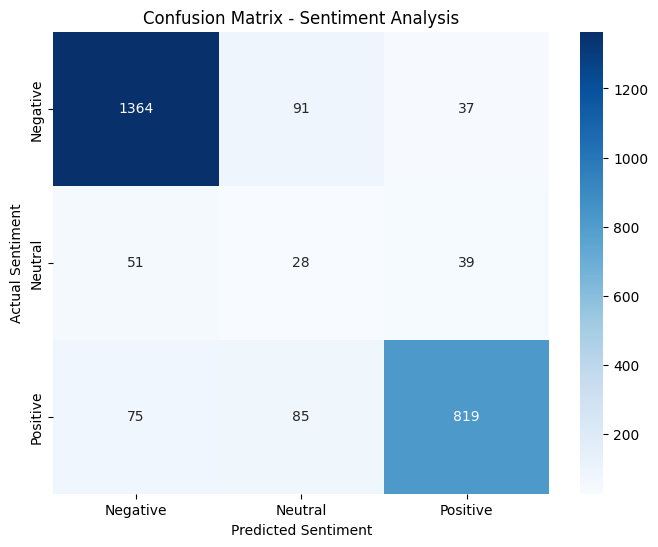



STEP 8: CREATING PREDICTED_SENTIMENT COLUMN
✅ predicted_sentiment column created!

Comparison between actual rating sentiment and predicted sentiment:
Actual sentiment from ratings:
sentiment_rating
negative    7457
positive    4897
neutral      589
Name: count, dtype: int64

Predicted sentiment from reviews:
predicted_sentiment
negative    7227
positive    4631
neutral     1085
Name: count, dtype: int64


STEP 9: FEATURE IMPORTANCE ANALYSIS

Top 10 features for negative sentiment:
  worst: 3.6799
  account: 2.9188
  horrible: 2.7850
  told: 2.2898
  cancel: 2.2448
  terrible: 2.2417
  money: 2.1179
  joke: 2.0882
  poor: 1.9340
  disgusting: 1.8770

Top 10 features for neutral sentiment:
  average: 3.3714
  okay: 2.9928
  slow: 2.7775
  ok: 2.7057
  bad: 2.6366
  end: 2.3566
  nice: 2.2409
  lately: 2.2199
  search: 2.2012
  needs: 2.0775

Top 10 features for positive sentiment:
  excellent: 4.3630
  great: 3.7916
  best: 3.5164
  amazing: 3.5107
  love: 3.3354
  fast: 3.1211
  quic

In [9]:
# Load the cleaned dataset
print("Loading cleaned dataset...")
df = pd.read_csv("../raw_data/review_for_amazon_fully_cleaned.csv")


# 2. Prepare Features and Target
# Use comment as the main feature
X = df['comment']  # Text features
y = df['sentiment_rating']  # Target variable

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")


# 3. Train-Test Split
print("\n\nSTEP 3: TRAIN-TEST SPLIT")


# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class distribution in splits
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining set sentiment distribution:\n{y_train.value_counts()}")
print(f"\nTest set sentiment distribution:\n{y_test.value_counts()}")

# 4. Create TF-IDF Vectorizer
print("\n\nSTEP 4: CREATING TF-IDF FEATURES")

# Initialize TF-IDF Vectorizer with optimal parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,           # Keep top 5000 features
    min_df=5,                    # Ignore terms that appear in less than 5 documents
    max_df=0.7,                  # Ignore terms that appear in more than 70% of documents
    ngram_range=(1, 2),          # Use both unigrams and bigrams
    stop_words='english',        # Remove common English stop words
    lowercase=True,              # Convert to lowercase
    strip_accents='unicode'      # Remove accents
)
# 5. Build Logistic Regression Model
print("\n\nSTEP 5: BUILDING LOGISTIC REGRESSION MODEL")


# Create pipeline: TF-IDF + Logistic Regression
lr_pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'  # Handle class imbalance
    ))
])

print("Pipeline created:\n 1. TF-IDF Vectorizer → 2. Logistic Regression \n\nLogistic Regression parameters: ")

# 6. Train the Model
print("\n\nSTEP 6: TRAINING THE MODEL")

print("Training the model...")
lr_pipeline.fit(X_train, y_train)
print("✅ Model training completed!")

# 7. Model Evaluation
print("\n\nSTEP 7: MODEL EVALUATION")

# Make predictions
y_pred = lr_pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"📊 Model Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\n📈 Detailed Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("🔍 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                    index=['Actual Negative', 'Actual Neutral', 'Actual Positive'],
                    columns=['Pred Negative', 'Pred Neutral', 'Pred Positive'])
print(cm_df)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - Sentiment Analysis')
plt.ylabel('Actual Sentiment')
plt.xlabel('Predicted Sentiment')
plt.show()

# 8. Create predicted_sentiment column for entire dataset
print("\n\nSTEP 8: CREATING PREDICTED_SENTIMENT COLUMN")

# Make predictions on the entire dataset using the review text
df['predicted_sentiment'] = lr_pipeline.predict(df['comment'])

print("✅ predicted_sentiment column created!")

print("\nComparison between actual rating sentiment and predicted sentiment:")
print("Actual sentiment from ratings:")
print(df['sentiment_rating'].value_counts())
print("\nPredicted sentiment from reviews:")
print(df['predicted_sentiment'].value_counts())

# 9. Feature Importance Analysis
print("\n\nSTEP 9: FEATURE IMPORTANCE ANALYSIS")

# Get the logistic regression model from the pipeline
lr_model = lr_pipeline.named_steps['classifier']
feature_names = lr_pipeline.named_steps['tfidf'].get_feature_names_out()

# Get coefficients for each class
coefficients = lr_model.coef_

# Display top features for each sentiment class
sentiment_classes = ['negative', 'neutral', 'positive']
for i, sentiment in enumerate(sentiment_classes):
    print(f"\nTop 10 features for {sentiment} sentiment:")
    # Get indices of top 10 features for this class
    top_indices = coefficients[i].argsort()[-10:][::-1]
    for idx in top_indices:
        print(f"  {feature_names[idx]}: {coefficients[i][idx]:.4f}")

# 10. Model Performance Analysis
print("\n\nSTEP 10: MODEL PERFORMANCE ANALYSIS")

# Predict on training set to check for overfitting
y_train_pred = lr_pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"📊 Training Accuracy: {train_accuracy:.4f}")
print(f"📊 Test Accuracy: {accuracy:.4f}")

if train_accuracy - accuracy > 0.1:
    print("⚠️  Warning: Potential overfitting detected!")
else:
    print("✅ Model generalization looks good!")

# 11. Save the Model and Updated Dataset
print("\n\nSTEP 11: SAVING THE MODEL AND UPDATED DATASET")

# Save the entire pipeline
model_filename = "../models/amazon_sentiment_model.pkl"
joblib.dump(lr_pipeline, model_filename)
print(f"✅ Model saved as: {model_filename}")

# Save the dataset with predicted sentiments
updated_dataset_path = "../raw_data/review_for_amazon_with_predictions.csv"
df.to_csv(updated_dataset_path, encoding='utf-8', index=False)
print(f"✅ Updated dataset with predictions saved as: {updated_dataset_path}")

print("\n\n🚀 AMAZON SENTIMENT ANALYSIS COMPLETED!")